In [1]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import FastICA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier



In [2]:
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230519_zikken'
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230529_1_zikken'
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230620_zikken'
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230622_zikken'
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230713'


# filePath = 'G:/マイドライブ/実験データ/20230519_zikken'
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']



motor_brainAdress = [9,10,11,12,13,17,18,31,44,45,46,47,48,49,50,54,55]




# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data = list()
label_data = list()#labelを結合したデータ


All_data = list()  # 全データを結合

def Standardization(data): #標準化
    after_data = scipy.stats.zscore(data)
    #b = np.average(after_data)
    #c = np.var(after_data)
    return after_data

file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
['EEG_grasping_13-Jul-2023_sub1-1.mat', 'EEG_grasping_13-Jul-2023_sub1-2.mat', 'EEG_grasping_13-Jul-2023_sub2-1.mat', 'EEG_grasping_13-Jul-2023_sub2-3.mat', 'EEG_grasping_13-Jul-2023_sub2-4.mat', 'EEG_grasping_13-Jul-2023_sub3-1.mat', 'EEG_grasping_13-Jul-2023_sub3-2.mat', 'EEG_grasping_13-Jul-2023_sub3-3.mat', 'EEG_grasping_13-Jul-2023_sub3-4.mat', 'EEG_grasping_13-Jul-2023_sub2-2.mat']


In [3]:
#解析するデータを選択
#file_name1 = [file_name[2],file_name[3],file_name[4],file_name[9]]
file_name1 = [file_name[5],file_name[6],file_name[7],file_name[8]]
file_num1 = len(file_name1)
trial_num = 30
all_trial = len(file_name1) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:66, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
print("image data_loading")
print(file_name1)

image data_loading
['EEG_grasping_13-Jul-2023_sub3-1.mat', 'EEG_grasping_13-Jul-2023_sub3-2.mat', 'EEG_grasping_13-Jul-2023_sub3-3.mat', 'EEG_grasping_13-Jul-2023_sub3-4.mat']


In [4]:
c1 = o_data65_label1[0].eeg[: , 0:10240]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[: , 0:10240]
    c1 = np.dstack([c1, g1])
all_data = c1.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)

(120, 66, 10240)


In [5]:
filter_bandpass = signal.firwin(numtaps=51,cutoff=[6,40],fs = 1024,pass_zero=False)
task_kind = 2
par_task = 60
CH = 64
for n in range(task_kind):
    for j in range(par_task):
        for k in range(CH):
            all_data[n*60+j][k]= abs(all_data[n*60+j][k]-np.mean(all_data[n*60+j][0:64],axis=0))
            all_data[n*60+j][k] = signal.lfilter(filter_bandpass,1,all_data[n*60+j][k])
#all_data = scipy.stats.zscore(all_data)

In [6]:
np.shape(all_data)

(120, 66, 10240)

In [7]:
label_data = list()#labelを結合したデータ
for n in range(all_trial):
    label_data.append(o_data65_label1[n].label)
print(label_data)
print(np.shape(label_data))

[1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1]
(120,)


In [8]:
processed_task = all_data[:,range(64),1024*8:1024*10]

csp_train = all_data[:,range(64),1024*6:1024*8]


In [9]:
class_data = processed_task
csp_class_data = csp_train
class_label = label_data

In [10]:
np.shape(class_data)

(120, 64, 2048)

In [11]:
class_data_reshape = np.reshape(class_data,(120,64*1024*2))
X_train, X_test, Y_train, Y_test = train_test_split(class_data_reshape,class_label, test_size=0.25,random_state=42)
model =SVC(kernel='linear')
model.fit(X_train,Y_train)
print(model.score(X_test, Y_test))

0.6666666666666666


In [12]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=2, log=None, reg=None)
csp = CSP(n_components=8, reg=None, norm_trace=False, transform_into='average_power',cov_est='epoch')
# Use scikit-learn Pipeline with cross_val_score function
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('biosemi64')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>

Computing rank from data with rank=None
    Using tolerance 4.6e+04 (2.2e-16 eps * 64 dim * 3.2e+18  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+04 (2.2e-16 eps * 64 dim * 3.2e+18  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e+04 (2.2e-16 eps * 64 dim * 3.2e+18  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e+04 (2.2e-16 eps * 64 dim * 3.2e+18  max singular value)


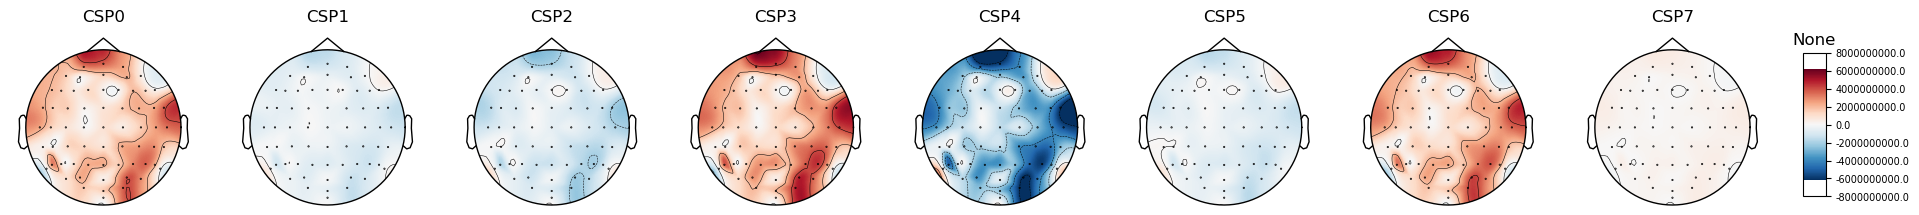

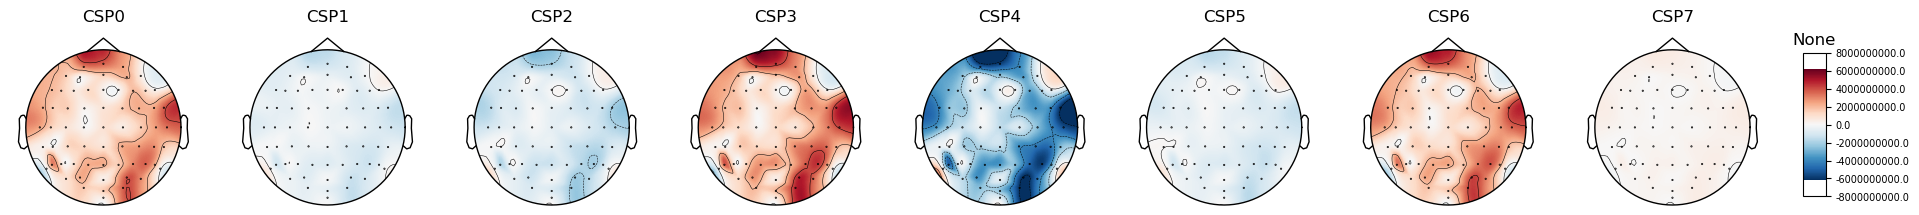

In [13]:
# Printing the results
class_balance = np.mean(class_label == class_label[0])
class_balance = max(class_balance, 1. - class_balance)
#print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),class_balance))

# plot CSP patterns estimated on full data for visualization
kenshou = csp.fit_transform(csp_class_data, class_label)
csp.fit_transform(csp_class_data, class_label)
csp.plot_patterns(info,ch_type='eeg', units='None', size=1.5)

In [14]:
print(np.shape(kenshou))

(120, 8)


In [15]:
class_data_cspfit = csp.transform(class_data)
# class_data_cspfit = np.reshape(class_data_cspfit,(84,4*6144))
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(class_data_cspfit,class_label, test_size=0.25,random_state=42)
model =SVC(kernel='linear')
model.fit(X_train2,Y_train2)
print(model.score(X_test2, Y_test2))

0.9666666666666667


In [16]:
params = {
    "C":np.logspace(-2,10,13),
    "kernel":[ "poly", "rbf", "sigmoid"],
    "gamma":np.logspace(-9,3,13)
}
grid = GridSearchCV(model, params,scoring="accuracy", cv=5)

grid.fit(X_train2, Y_train2)

print("grid_best_score=",grid.best_score_)
print(grid.best_params_)

pred = grid.predict(X_test2)
print(classification_report(Y_test2, pred))

grid_best_score= 0.9555555555555555
{'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        16
           2       1.00      0.93      0.96        14

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



In [17]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

%matplotlib inline

In [18]:
#PCAを用意
pca = PCA(n_components=2)
#PCAで次元圧縮
pca.fit(X_train2)
#PCAの結果を元にデータを変換
pca_X = pca.transform(X_train2)

Text(0, 0.5, 'x2')

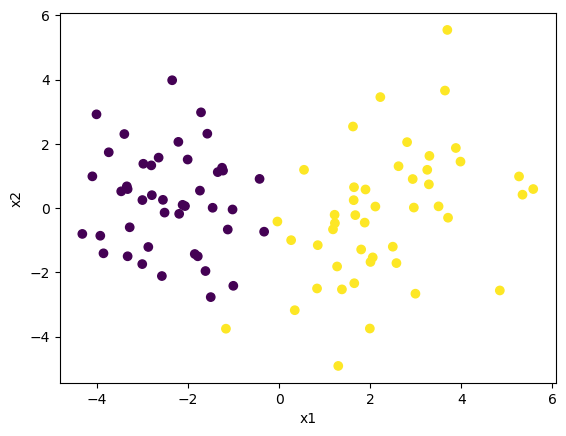

In [19]:
#SVNデータの点を表示
Z = grid.predict(X_train2)

plt.scatter(pca_X[:,0], pca_X[:,1], c=Z)
plt.xlabel("x1")
plt.ylabel("x2")